# Basic Tutorial

> The main abstractions in `emb_opt` and how to use them

## Overview

The goal of `emb_opt` is to use hill climbing to find high scoring items (defined by some score function) in a vector database without exhaustive screening of the database itself.

`emb_opt` takes advantage of the inherent structure present in embedding spaces. Starting with random points, we can use reinforcement learning to traverse the vector space to move from low scoring items to high scoring items.

This notebook gives an overview of the main abstractions in `emb_opt` and how they fit together.

In [ ]:
from emb_opt.imports import *
from emb_opt.schemas import Query, Item, Batch

import string
from datasets import Dataset

import matplotlib.pyplot as plt

/home/dmai/miniconda3/envs/emb_opt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup

First we need a vector database to query. Since this is a simple example notebook, we will work off a set of random vectors.

We will use the [Datasets](https://huggingface.co/docs/datasets/index) library to hold our vectors and build our index.

Our dataset will contain the following columns:
* `index` - the ID of each item
* `item` - the specific thing each embedding represents (in this case a random text string)
* `rand` - a random number we will use for filtering
* `embedding` - the embedding itself

In [ ]:
n_vectors = 10000
size = 64

np.random.seed(42)
vectors = np.random.randn(n_vectors, size)

vector_data = [{
                'index' : i,
                'item' : ''.join(np.random.choice([i for i in string.ascii_lowercase], size=10).tolist()),
                'rand' : np.random.rand(),
                'embedding' : vectors[i]
            } for i in range(n_vectors)]

vector_dataset = Dataset.from_list(vector_data)
vector_dataset.add_faiss_index('embedding')

100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 1101.59it/s]


Dataset({
    features: ['index', 'item', 'rand', 'embedding'],
    num_rows: 10000
})

## Data Models

`emb_opt` uses Pydantic data models to standardize inputs and outputs of various modules. Here we introduce several relevant data models.

### Item Data Model

The `Item` data model is the standard format for something returned from a vector database

```python
class Item(BaseModel):
    id: Optional[Union[str, int]] # id/index of item
    item: Optional[Any]           # the item itself
    embedding: List[float]        # embedding representing the item
    score: Optional[float]        # item score
    data: Optional[dict]          # any other associated data
```

* `Item.id` is expected to be unique
* `Item.item` is the object associated with the embedding. This field is optional, allowing for working purely in embedding space
* `Item.embedding` is the item's embedding
* `Item.score` is the item's score, which will be computed at a later point
* `Item.data` is a dictionary of any other associated data


### Query Data Model

The `Query` data model is the standard format for making a query to a vector database

```python
class Query(BaseModel, extra='allow'):
    item: Optional[Any]                  # Optional item associated with query
    embedding: List[float]               # Query embedding
    data: Optional[dict]                 # data associated with the query
    query_results: Optional[list[Item]]  # list of `Item` query results
```

* `Query.item` is the object associated with the embedding. If the `Query` is created from a specific `Item`, this field will be populated with `Item.item`. If the `Query` is a pure embedding query (ie created by averaging embeddings or a similar embedding-space process), `Query.item` will be `None`
* `Query.embedding` is the query embedding
* `Query.data` is a dictionary of any data related to the query
* `Query.query_results` is a list of `Item` results returned by the query

## Data Source

Now we need to convert our vector database into a format compatible with `emb_opt`. To integrate a data source, it must be compatible with the `DataSourceFunction` data model:

```python
DataSourceFunction = Callable[List[Query], List[DataSourceResponse]]

class DataSourceResponse(BaseModel):
    valid: bool                # if input `Query` was valid (if False, associated `Query` is removed)
    data: Optional[Dict]       # optional dict of data associated with the query
    query_results: List[Item]  # list of `Item` results
```

For more details, see the `DataSourcePlugin` documentation.

Our dataset is a Huggingface dataset, so we will use the `HugggingfaceDataPlugin` class from the plugins library. `emb_opt` currently supports data plugins for [faiss](https://github.com/facebookresearch/faiss), [Qdrant](https://qdrant.tech/), and [Huggingface Datasets](https://huggingface.co/docs/datasets/index).

In [ ]:
from emb_opt.plugins.huggingface import HugggingfaceDataPlugin

In [ ]:
k = 10 # return 10 items per query

data_plugin = HugggingfaceDataPlugin(k=k, 
                                     dataset=vector_dataset, 
                                     index_name='embedding', 
                                     item_key='item', 
                                     id_key='index', 
                                     distance_cutoff=None
                                    )

## Score Function

This is the score we want to maximize. To be compatible with `emb_opt`, the score function must be compatible with the `ScoreFunction` data model: 

```python
ScoreFunction = Callable[List[Item], List[ScoreResponse]]

class ScoreResponse(BaseModel):
    valid: bool             # if the input `Item` is valid (if False, associated `Item` is removed)
    score: Optional[float]  # the score of the input `Item`. Can be `None` if `valid=False`
    data: Optional[Dict]    # optional dict of data associated with the score response
```

For more details, see the `ScorePlugin` documentation.

For our score function, we will use a function that has a maxima at the point `[0.75, 0.75, ... 0.75]` and a score value that decays exponentially with respect to distance from that point.

`score_embeddings` will compute the score using numpy arrays, and `score_plugin` will wrap this function to make the inputs and outputs compatible with the `ScoreFunction` data model

In [ ]:
from emb_opt.schemas import ScoreResponse

In [ ]:
def score_embeddings(embeddings: np.ndarray, sigma: float=5.) -> np.ndarray:
    target_point = np.ones(embeddings.shape[1])*.75
    
    distances = np.linalg.norm(embeddings - target_point, axis=1) / np.sqrt(embeddings.shape[1])
    
    scores = np.exp(-0.5 * (distances/sigma)**2)
        
    return scores

def score_plugin(inputs: List[Item]) -> List[ScoreResponse]:
    embeddings = np.array([i.embedding for i in inputs])
    scores = score_embeddings(embeddings)    
    results = [ScoreResponse(valid=True, score=i, data=None) for i in scores]
    return results

## Filter Function

In some cases, we may wish to filter scores prior to scoring. We can implement filtering directly in the score function using the `ScoreResponse.valid` field, but it may be more efficient to separate the steps as filtering before scoring allows us to removed items that fail the filter and rebatch only valid items for scoring.

Filter functions are defined by the `FilterFunction` data model

```python
FilterFunction = Callable[List[Item], List[FilterResponse]]

class FilterResponse(BaseModel):
    valid: bool           # if the input `Item` is valid (if False, associated `Item` is removed)
    data: Optional[Dict]  # optional dict of data associated with the filter response
```

For more details, see the `FilterPlugin` documentation.

When we generated our dataset, we added a `rand` column containing a random value between 0 and 1. As an example filter function, we will reject any item where `rand >= 0.9`

In [ ]:
from emb_opt.schemas import FilterResponse

In [ ]:
def filter_plugin(inputs: List[Item]) -> List[FilterResponse]:
    return [FilterResponse(valid=i.data['rand']<0.9, data={'rand':i.data['rand']}) for i in inputs]

## Update Function

After filtering and scoring, every `Query` will have a list of query result `Item` objects that have been scored. The update step uses this information to generate a new query.

We can use any update method that corresponds to the `UpdateFunction` data model

```python
UpdateFunction = Callable[List[Query], List[UpdateResponse]]

class UpdateResponse(BaseModel):
    query: Query                # the new `Query`
    parent_id: Optional[str]    # optional parent query ID, used for tracking query progression
```

For this example, we will use reinforcement learning to estimate the gradient of the query based on the scored results, and use gradient descent to update.

In [ ]:
from emb_opt.update import RLUpdate

In [ ]:
update_plugin = RLUpdate(lrs=[.25], distance_penalty=0.)

## Runner

The `Runner` class holds all these objects together and executes the search. The search algorithm follows:
1. Query the data source
2. Filter results
3. Score results
4. Use scores to create new queries

In [ ]:
from emb_opt.runner import Runner

In [ ]:
# the `None` keyword corresponds to a prune plugin, which is explained in another tutorial
runner = Runner(data_plugin, filter_plugin, score_plugin, None, update_plugin)

## Initialize

We start with 5 random query embeddings. These are converted into a `Batch` using the `build_batch_from_embeddings` function. The `Batch` data model holds a list of embeddings, with several helper functions for iterating over queries and query results

In [ ]:
from emb_opt.utils import build_batch_from_embeddings

In [ ]:
n_queries = 5
np.random.seed(40)
initial_queries = np.random.randn(n_queries, size)

input_batch = build_batch_from_embeddings(initial_queries)

## Run

Running the input batch generates `output_batch`, the result of the final `update` step, and `search_log`, which contains all the found results

In [ ]:
output_batch, search_log = runner.search(input_batch, 15)

0 0.97 0.97 0.97 0.97 0.98
1 0.98 0.97 0.98 0.97 0.98
2 0.98 0.97 0.98 0.97 0.98
3 0.98 0.98 0.98 0.97 0.98
4 0.98 0.98 0.98 0.97 0.98
5 0.98 0.98 0.98 0.98 0.98
6 0.98 0.98 0.98 0.98 0.98
7 0.98 0.98 0.98 0.98 0.98
8 0.98 0.98 0.98 0.98 0.98
9 0.98 0.98 0.98 0.98 0.98
10 0.98 0.98 0.98 0.98 0.98
11 0.98 0.98 0.98 0.98 0.98
12 0.98 0.98 0.98 0.98 0.98
13 0.98 0.98 0.98 0.98 0.98
14 0.98 0.98 0.98 0.98 0.98


## Eval

Now we want to evaluate the outputs. First we need the ground truth from our dataset

In [ ]:
ground_truth = vector_dataset.map(lambda row: 
                            {'score' : float(score_embeddings(np.array(row['embedding'])[None]))})
ground_truth = ground_truth.filter(lambda row: row['rand']<0.9)
ground_truth = ground_truth.sort('score', reverse=True)

Now we'll grab the results from the `search_log`

In [ ]:
results = search_log.compile_results(skip_removed=False)
len(results)

186

The search log contains 186 items. This represents a 1.8% screening of the total search space.

Now we'll look at the fraction of top k ground truth items recovered.

We can see the queries successfully found the top scoring result, but only 40% of the top 10 results. Methods to tune performance are discussed in other tutorials.

In [ ]:
k_vals = [1, 5, 10, 50]
recovered_ids = set([i['id'] for i in results])
metrics = []

for k in k_vals:
    gt_idxs = set(ground_truth[:k]['index'])
    percent_recovered = len(gt_idxs.intersection(recovered_ids))/k
    metrics.append(percent_recovered)
    
metrics

[1.0, 0.4, 0.4, 0.2]

The `search_log` also contains a `query_tree` which maps out the progression of queries through the search. We can use this to reconstruct trajectories of the average score over the search

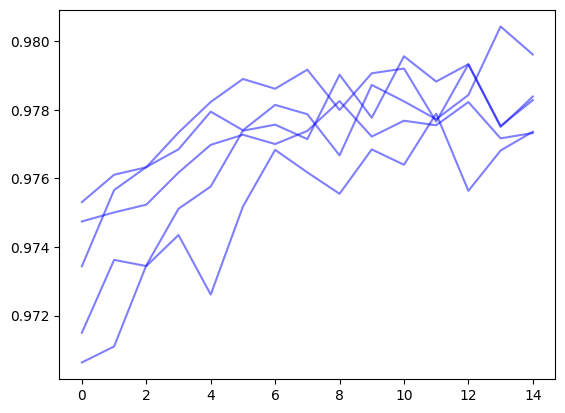

In [ ]:
for final_node in search_log.query_tree.leaf_nodes():
    max_scores = []
    
    current = final_node
    while current:
        max_scores.append(current.mean_score)
        current = current.parent
        
    plt.plot(max_scores[::-1], color='b', alpha=0.5)

## Coments on results

The compiled results returned 186 items. We used 5 query vectors with 10 items returned per query over 15 iterations. This implies 750 total items should have been returned. The reduction from 750 total items to 186 is a result of the query vectors converging to the same location and returning duplicate items.

The degree of duplicate results depends on:
* size of the vector database
* how query vectors are initialized
* how many local optima exist for your score function
* how many iterations are run
* how many results are returned per query

## Conclusions

This notebook gave a brief overview of the main components of `emb_opt`. We used hill climbing to find the top scoring item in a vector dataset while only evaluating 1.8% of the total search space.

The next set of tutorials will go over advanced usage of the library and methods to tune performance.